# <font color = 'green'> IMPUTATION OF MISSING DATA (Group Assignment)

####  Adapted from "Statistical Imputation for Missing Values in Machine Learning" by Jason Brownlee (May 2020).
(https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/)

##### <font color = 'green'> Group Members: 
    1. Ramya Prakash
    2. Soumyadip Mitra
    3. Kirk Mason (James Mason)
    4. Hari Chamlagai
    5. Phil Nguyen

Date: 7/18/2020

### Import libraries:

In [1]:
# Import libraries
from numpy import mean
from numpy import std
from numpy import isnan
from numpy import nan
from numpy import random
from numpy import copy
import numpy as np
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from matplotlib import pyplot

### Load and explore data:

In [2]:
#Load the Data
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/horse-colic.csv'
dataframe = read_csv(url, header=None, na_values='?')

#Summary of the dataframe
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       299 non-null    float64
 1   1       300 non-null    int64  
 2   2       300 non-null    int64  
 3   3       240 non-null    float64
 4   4       276 non-null    float64
 5   5       242 non-null    float64
 6   6       244 non-null    float64
 7   7       231 non-null    float64
 8   8       253 non-null    float64
 9   9       268 non-null    float64
 10  10      245 non-null    float64
 11  11      256 non-null    float64
 12  12      244 non-null    float64
 13  13      196 non-null    float64
 14  14      194 non-null    float64
 15  15      53 non-null     float64
 16  16      198 non-null    float64
 17  17      182 non-null    float64
 18  18      271 non-null    float64
 19  19      267 non-null    float64
 20  20      135 non-null    float64
 21  21      102 non-null    float64
 22  22

In [3]:
# Look at the first five rows
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,2.0,1,530101,38.5,66.0,28.0,3.0,3.0,NaN,2.0,...,45.0,8.4,NaN,NaN,2.0,2,11300,0,0,2
1,1.0,1,534817,39.2,88.0,20.0,NaN,NaN,4.0,1.0,...,50.0,85.0,2.0,2.0,3.0,2,2208,0,0,2
2,2.0,1,530334,38.3,40.0,24.0,1.0,1.0,3.0,1.0,...,33.0,6.7,NaN,NaN,1.0,2,0,0,0,1
3,1.0,9,5290409,39.1,164.0,84.0,4.0,1.0,6.0,2.0,...,48.0,7.2,3.0,5.3,2.0,1,2208,0,0,1
4,2.0,1,530255,37.3,104.0,35.0,NaN,NaN,6.0,2.0,...,74.0,7.4,NaN,NaN,2.0,2,4300,0,0,2


### Count missing values in each column:

In [4]:
# Obtain number of rows with missing values for each column
for i in range(dataframe.shape[1]):
    n_miss = dataframe[[i]].isnull().sum()
    perc = n_miss / dataframe.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> 0, Missing: 1 (0.3%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 0 (0.0%)
> 3, Missing: 60 (20.0%)
> 4, Missing: 24 (8.0%)
> 5, Missing: 58 (19.3%)
> 6, Missing: 56 (18.7%)
> 7, Missing: 69 (23.0%)
> 8, Missing: 47 (15.7%)
> 9, Missing: 32 (10.7%)
> 10, Missing: 55 (18.3%)
> 11, Missing: 44 (14.7%)
> 12, Missing: 56 (18.7%)
> 13, Missing: 104 (34.7%)
> 14, Missing: 106 (35.3%)
> 15, Missing: 247 (82.3%)
> 16, Missing: 102 (34.0%)
> 17, Missing: 118 (39.3%)
> 18, Missing: 29 (9.7%)
> 19, Missing: 33 (11.0%)
> 20, Missing: 165 (55.0%)
> 21, Missing: 198 (66.0%)
> 22, Missing: 1 (0.3%)
> 23, Missing: 0 (0.0%)
> 24, Missing: 0 (0.0%)
> 25, Missing: 0 (0.0%)
> 26, Missing: 0 (0.0%)
> 27, Missing: 0 (0.0%)


### Separate dependent variable from independent variables:

In [5]:
# split the data set into dependent and independent variables
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:,ix], data[:,23]

### Practice imputing using SimpleImputer:

In [6]:
# print total missing before imputation
print('Missing: %d' % sum(isnan(X).flatten()))

# define imputer
imputer = SimpleImputer(strategy='mean')
# fit on the dataset
imputer.fit(X)
# transform the data set
Xtrans = imputer.transform(X)

# print total missing after imputation
print('Missing: %d' % sum(isnan(Xtrans).flatten()))

Missing: 1605
Missing: 0


### Practice using a pipeline:

In [7]:
# Set random seed for reproducability

# (Decided to use the random_state argument in RandomForestClassifier instead, so commented this out.)
# random.seed(456789)

In [8]:
# define modeling pipeline
model = RandomForestClassifier(random_state=456789)
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
# print()
# print('SCORES:')
# print(scores)

Mean Accuracy: 0.863 (0.050)


### Compare different imputation strategies:

In [9]:
# evaluate each strategy on the dataset
results = list()
strategies = ['mean', 'median', 'most_frequent', 'constant']
for s in strategies:
    # create the modeling pipeline
    model = RandomForestClassifier(random_state=456789)
    imputer = SimpleImputer(strategy=s)
    pipeline = Pipeline(steps = [('i', imputer), ('m', model)])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=1)
    # store results
    results.append(scores)
    print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))

>mean 0.863 (0.050)
>median 0.866 (0.054)
>most_frequent 0.867 (0.055)
>constant 0.877 (0.055)


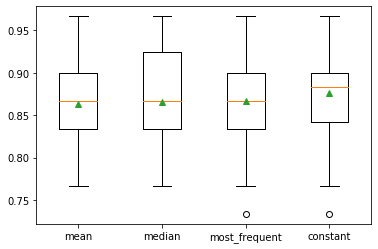

In [10]:
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

### Transform while making a prediction:

In [11]:
# create a modeling pipeline
model = RandomForestClassifier(random_state=456789)
imputer = SimpleImputer(strategy='constant')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# fit the model
pipeline.fit(X,y)
# define new data
row = [2, 1, 530101, 38.50, 66, 28, 3, 3, nan, 2, 5, 4, 4, nan, nan, nan, 3, 5, 45.00, 8.40, nan, nan, 2, 11300, 00000, 00000, 2]
# make prediction
yhat = pipeline.predict([row])
# summarize prediction
print('Predicted Class: %d' % yhat[0])

Predicted Class: 2


### Imputation with K-NN:
Resources:
<p><a href='https://datascienceplus.com/knnimputer-for-missing-value-imputation-in-python-using-scikit-learn/'</a> https://datascienceplus.com/knnimputer-for-missing-value-imputation-in-python-using-scikit-learn/ </p>

<p><a href='https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779'</a>https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779</p>


In [12]:
# Test out imputation using KNN
KNN_imputer = KNNImputer(n_neighbors=3)
X_filled = KNN_imputer.fit_transform(X)

# print total missing after imputation
print('Missing: %d' % sum(isnan(Xtrans).flatten()))

Missing: 0


In [13]:
# Employ cross validation, filling in missing values using KNN

# Copy "results" list from several cells above
results2 = results.copy()

# create new modeling pipeline
model = RandomForestClassifier(random_state=456789)
KNN_imputer = KNNImputer(n_neighbors=3)
pipeline = Pipeline(steps = [('i', KNN_imputer), ('m', model)])

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=1)

# store results
results2.append(scores)
print('>%s %.3f (%.3f)' % ('K-NN', mean(scores), std(scores)))

>K-NN 0.863 (0.052)


### Final comparison of all attempted imputation strategies:

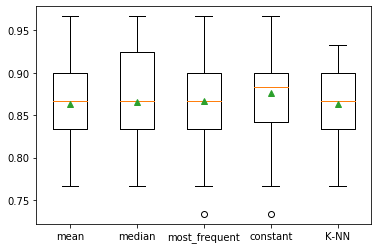

In [14]:
# plot model performances for comparison of all imputation methods used
strategies2 = ['mean', 'median', 'most_frequent', 'constant', 'K-NN']
pyplot.boxplot(results2, labels=strategies2, showmeans=True)
pyplot.show()

_____________________________________________________________________________________________

## <font color = 'green'> ANSWERS TO HOMEWORK QUESTIONS:

#### Question 1: Three ways to handle missing data 

One way to handle missing data is to do nothing about missing data and let the modeling algorithm handle the missing values. Some algorithms will simply drop records with missing data. This may not be ideal if missing values are not missing completely at random. Dropping all records with missing values might systematically remove certain similar groups, if the reason the values are missing is correlated to a particular feature of a particular group.

Another way to handle the missing values would be to impute using aggregate statistics (such as mean median or mode) or using a constant value (such as 0). These are quick and easy ways to fill in missing numeric data, but they do not do a good job of factoring in relationships that the imputed column might have with other columns in the data set. Mode (i.e. most common value) is usefull for imputing categorical variables, but it also doesn't account for correlations between features.

A third way to handle missing data is to use imputation by prediction, which would account for correlation between features. There are numerous models that can be used to predict values for missing data. You could use a simple linear regression for numeric variables. Another option could be K-NN, which assigns a value based on how closely a record resembles other records. An example of K-NN imputation was implemented above. Two more examples of predictive imputation methods are multivariate imputation by chained equation (MICE) and deep learning. It should be noted that several predictive imputation methods are computationally expensive. 

#### Question 2: Comparing strategies

In most circumstances, imputing missing values is better than leaving them missing. Many modeling algorithms will drop records with missing values, and this could result in bias if data is not missing completely at random. The question then becomes which imputation strategy to implement. Unfortunately, when dealing with missing data one size does not fit all. Different strategies might be appropriate for different columns within a data set. For example, the most common value might be sufficient for a categorical variable with few unique values, whereas a predictive model might be the best approach for imputing a numerical variable that is likely correlated with other columns in the data set.

In this assignment, five different imputation strategies were tested: mean, median, mode, constant value zero, and K-NN. Each strategy was applied to all columns of the data set, and then cross validation accuracies from a random forest model were compared to see which imputation strategy produced the best results. It should be noted that these results came from applying each strategy across the whole data set, so better performance might be acheived by using a combination of strategies, wherein strategies are tailored to the column being imputed. Based on the final boxplot shown above, the "constant" strategy seemingly outperformed all other strategies, even K-NN. The mean of the accuracies and the median of the accuracies were the highest when all missing values were imputed with the number 0. It should also be noted that given other random seeds, these results could change.

__________________________